# Predict duplicate questions on Quora

Step 1: Read data and perform EDA. 
    
Step 2: Preprocess data by removing punctuations, regular expressions, special characters, letter case, digits

Step 3: Visualize words using t-SNE

Step 4: Convert word to vectors and identify duplicate questions using cosine similarity


In [69]:
import numpy as np
import pandas as pd 
from collections import Counter
import operator, re, os, gc, string
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
pal = sns.color_palette()
color = sns.color_palette()
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)
pd.options.mode.chained_assignment = None  # default='warn'

words = re.compile(r"\w+",re.I)
stopword = stopwords.words('english')

In [2]:
# read data
train = pd.read_csv("qa_train.csv").fillna("")
test = pd.read_csv("qa_test.csv").fillna("")

In [3]:
# check # of rows and columns in test and train data
print(train.shape)
print(test.shape)

(49999, 6)
(49999, 5)


In [4]:
# check train dataset 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 6 columns):
id              49999 non-null int64
qid1            49999 non-null int64
qid2            49999 non-null int64
question1       49999 non-null object
question2       49999 non-null object
is_duplicate    49999 non-null int64
dtypes: int64(4), object(2)
memory usage: 2.3+ MB


We have eight columns and is_duplicate is the classification label

In [5]:
print('Let"s check first 5 rows')
train.head()

Let"s check first 5 rows


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [6]:
print('None of firt five rows are duplicate, let"s check duplicate questions')
train[train['is_duplicate']==1].head()

None of firt five rows are duplicate, let"s check duplicate questions


,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [7]:
#check first five test rows
test.head()

,id,qid1,qid2,question1,question2
0,49999,88910,88911,Why can some people hold their liquor so much better than others?,How do you make malt liquor taste better?
1,50000,88912,88913,Why is human cloning considered unethical?,Why is cloning considered unethical?
2,50001,88914,88915,What is Quora's monetization strategy?,Adam D'Angelo: What is Quora's monetization strategy?
3,50002,88916,88917,Is the Moto G4 Plus waterproof?,Should i buy a Moto G4 plus?
4,50003,88918,32373,Where can I get very nice and original flavor cupcakes in Gold Coast?,Where can I buy best quality gourmet cupcakes in Gold Coast?


In [8]:
print('Check if there are any empty columns')
print(train.isnull().sum())
print(test.isnull().sum())

Check if there are any empty columns
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64
id           0
qid1         0
qid2         0
question1    0
question2    0
dtype: int64


# Exploratory Data Analysis

We will now construct a basic set of features that will be  later use to embed our samples with.
The first we will be looking at is rather standard TF-IDF encoding for each of the questions. In order to limit the computational complexity and storage requirements we will only encode the top terms across all documents with TF-IDF and also look at a subsample of the data.

Check distribution of duplicate vs non-duplicate records


,id
is_duplicate,
0,31350
1,18649


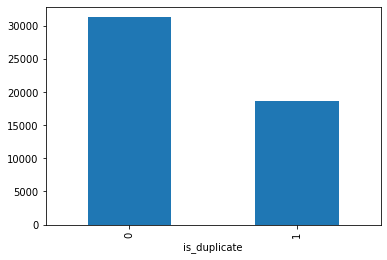

In [9]:
print('Check distribution of duplicate vs non-duplicate records')
dupVsnondup = train.groupby("is_duplicate")['id'].count()
dupVsnondup.plot.bar();
pd.DataFrame(dupVsnondup)

Check distribution of duplicate vs non-duplicate for first 2500 records
If it"s close to whole set, we will use this dataset 


,id
is_duplicate,
0,1549
1,951


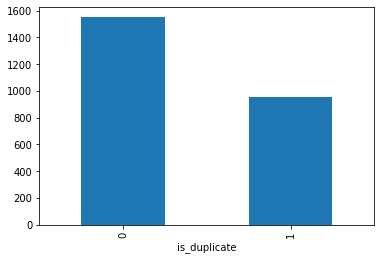

In [10]:
print('Check distribution of duplicate vs non-duplicate for first 2500 records');
print('If it"s close to whole set, we will use this dataset ')
dfs = train[0:2500]
dupVsnondup = dfs.groupby("is_duplicate")['id'].count()
dupVsnondup.plot.bar();
pd.DataFrame(dupVsnondup)

The subsample still has a very similar label distribution. For quicker analysis, combine question1 and question2 into a single column for further analysis. Top 50% of rows of dataframe will have question 1 and bottom 50% has question 2.

In [11]:
def eda(df, train):
    if (train):
          print ("Duplicate Count = %s , Non-Duplicate Count = %s" 
           %(df.is_duplicate.value_counts()[1],df.is_duplicate.value_counts()[0]))
    
    question_ids_combined = df.qid1.tolist() + df.qid2.tolist()
    
    print ("Unique Questions = %s" %(len(np.unique(question_ids_combined))))
    
    question_ids_counter = Counter(question_ids_combined)
    sorted_question_ids_counter = sorted(question_ids_counter.items(), key=operator.itemgetter(1))
    question_appearing_more_than_once = [i for i in question_ids_counter.values() if i > 1]
    print ("Count of Questions appearing more than once = %s" %(len(question_appearing_more_than_once)))
    
print('Training set:')    
eda(train, 1)
print('\nTest set:')
eda(test, 0)

Training set:
Duplicate Count = 18649 , Non-Duplicate Count = 31350
Unique Questions = 88909
Count of Questions appearing more than once = 7396

Test set:
Unique Questions = 88931
Count of Questions appearing more than once = 7421


In [12]:
dfq1, dfq2 = dfs[['qid1', 'question1']], dfs[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
dfqa.shape

(5000, 3)

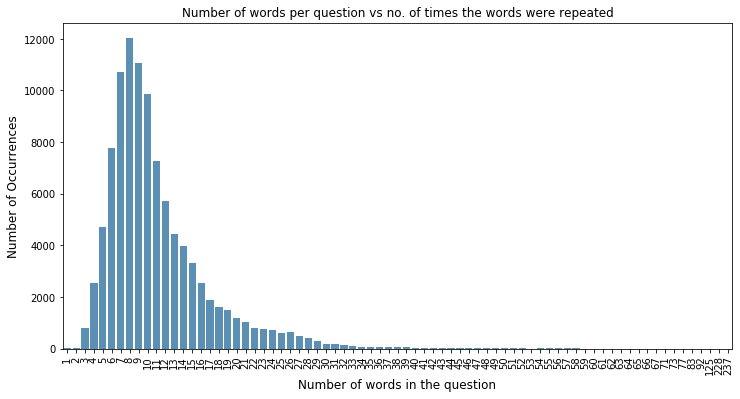

In [13]:
all_ques_df = pd.DataFrame(pd.concat([train['question1'], train['question2']]))
all_ques_df.columns = ["questions"]
all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))
cnt_srs = all_ques_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Number of words per question vs no. of times the words were repeated')
plt.show();

Total number of question pairs for training: 49999
Duplicate pairs: 37.3%
Total number of questions in the training data: 88909
Number of questions that appear multiple times: 7396




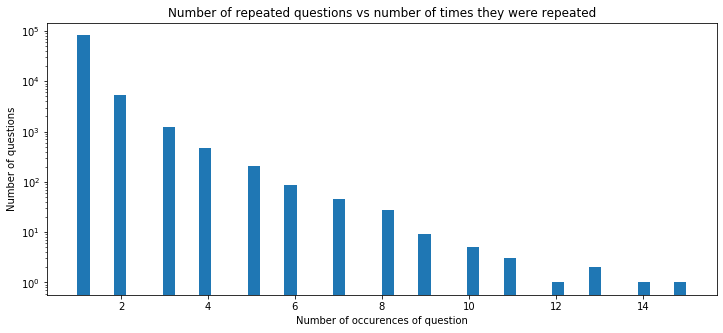

In [14]:
print('Total number of question pairs for training: {}'.format(len(train)))
print('Duplicate pairs: {}%'.format(round(train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len( np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

print()
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.title('Number of repeated questions vs number of times they were repeated')
print()

mean-train 59.77 std-train 32.07 mean-test 59.64 std-test 32.07 max-train 1169.00 max-test 1151.00


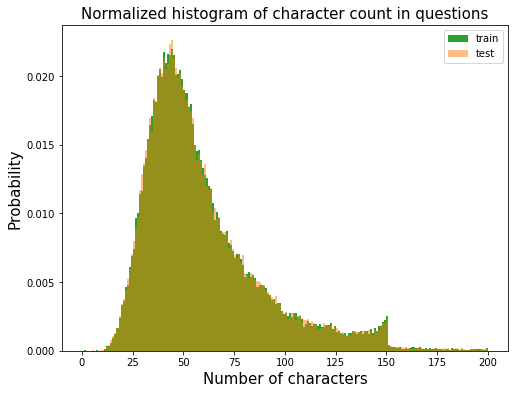

In [15]:
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
test_qs = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(8, 6))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalized histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We can see that most questions have anywhere from 15 to 150 characters. One thing to notice is steep cut-off at 150 characters.
Let's do the same for word count. We'll use a naive method for splitting words (splitting on spaces instead of using a  tokenizer), this should still give us a good idea of the distribution.

mean-train 11.05 std-train 5.91 mean-test 11.05 std-test 5.94 max-train 237.00 max-test 237.00


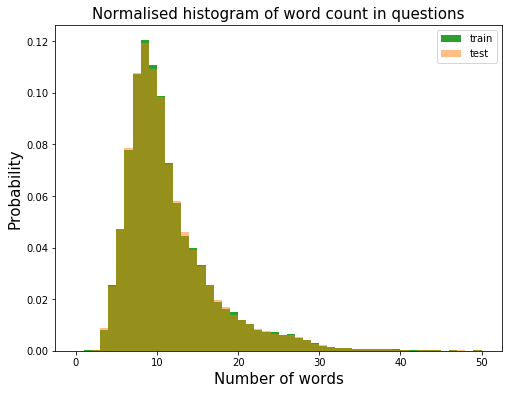

In [16]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(8,6))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

# t-SNE embedding

We will use t-SNE to embed word vectors in three dimensions and plot them. t-Distributed Stochastic Neighbor Embedding (t-SNE) is a  technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. 

In [17]:
import nltk
STOP_WORDS = nltk.corpus.stopwords.words()

In [18]:

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_&*)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_trainframe(df):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    df = df.dropna(how="any")
    
    for col in ['question1', 'question2']:
        df[col] = df[col].apply(clean_sentence)
    
    return df

df = clean_trainframe(train)
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor kohinoor diamond back,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math2324math divided 2423,0
4,4,9,10,dissolve water quikly sugar salt methane carbon oxide,fish would survive salt water,0


In [19]:
def build_corpus(df):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in df[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus


corpus = build_corpus(df)        
corpus[0:2]

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
 ['story', 'kohinoor', 'kohinoor', 'diamond']]

In [20]:
from gensim.models import word2vec
print('Create a word2vec for the corpus with 100 dimensions.')
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
print('Location of word "universe" in the word2vec.')
model.wv['universe']

Create a word2vec for the corpus with 100 dimensions.
Location of word "universe" in the word2vec.


array([ 0.11549157, -0.08254549, -0.27136043, -0.0931699 ,  0.4255142 ,
       -0.4614586 , -0.35727027,  0.21137868,  0.5521492 , -0.00420784,
        0.47218913, -0.8592244 , -0.29216886, -0.761837  ,  0.1328136 ,
        0.1796368 , -0.35069063, -0.8475501 ,  0.78930867,  0.5755038 ,
       -0.00563522, -0.6779833 ,  0.08096587, -0.05445635,  0.5788004 ,
        0.02449722,  0.6003969 , -0.06514224, -0.45094115,  0.04477476,
        0.06796074, -0.9005174 , -0.35786727, -0.65374047, -0.714597  ,
       -0.85679203,  0.39316094,  0.21696569, -0.00626419,  0.11971176,
        0.05256695,  0.05677013, -0.11234661, -0.31717974, -0.18080029,
        0.02778025, -0.2847401 , -0.47141874,  0.47770786,  0.00228657,
        0.03760432, -0.23111527, -0.9037618 ,  0.30208296, -0.40228763,
        0.6172494 ,  1.1586468 , -0.5231833 , -0.5997851 , -0.86532915,
        0.24490093, -0.15834557, -0.09193824,  0.31656736,  0.26151592,
       -0.3784276 ,  0.05253235, -0.14739391, -0.4790226 , -0.04

In [21]:
def tsne_plot(model):
    "Creates a TSNE model and plot"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    plt.title('t-SNE model')
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom');
    plt.show();

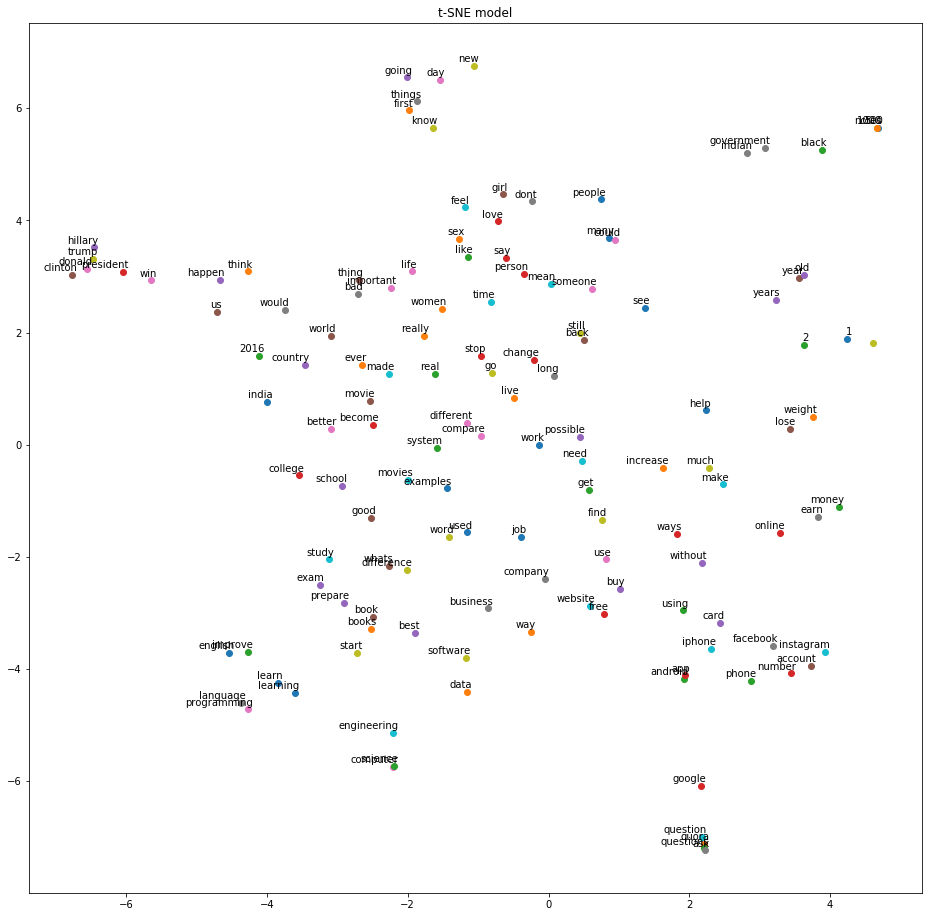

In [22]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500, workers=4)
tsne_plot(model)

Note that 'donald' and 'clinton' are together, also 'google', 'questions' and 'quora' are in same direction. We can also look up the most similar words for any word. 

In [23]:
print("Following are similar words for 'universe'")
model.wv.most_similar('quora')

Following are similar words for 'universe'


[('ask', 0.9896209239959717),
 ('questions', 0.9658547043800354),
 ('question', 0.9643120169639587),
 ('many', 0.903973400592804),
 ('google', 0.9007415771484375),
 ('could', 0.9002904891967773),
 ('people', 0.7901384830474854),
 ('need', 0.769147515296936),
 ('mean', 0.7495986819267273),
 ('find', 0.7470552921295166)]

# Question Similarity

In [24]:
def tokenize_questions(df):
    question_1_tokenized = []
    question_2_tokenized = []

    for q in df.question1.tolist():
        question_1_tokenized.append([i.lower() for i in words.findall(q) if i not in stopword])

    for q in df.question2.tolist():
        question_2_tokenized.append([i.lower() for i in words.findall(q) if i not in stopword])

    df["Question_1_tok"] = question_1_tokenized
    df["Question_2_tok"] = question_2_tokenized
    
    return df

def train_dictionary(df):
    
    questions_tokenized = df.Question_1_tok.tolist() + df.Question_2_tok.tolist()
    
    dictionary = corpora.Dictionary(questions_tokenized)
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=10000000)
    dictionary.compactify()
    
    return dictionary
    
df_train = tokenize_questions(train)
dictionary = train_dictionary(df_train)

print ("No of words in the dictionary = %s" %len(dictionary.token2id))

No of words in the dictionary = 10459


In [78]:
def get_vectors(df, dictionary):
    
    # Convert text into the bag-of-words (BoW) format 
    question1_vec = [dictionary.doc2bow(text) for text in df.Question_1_tok.tolist()]
    question2_vec = [dictionary.doc2bow(text) for text in df.Question_2_tok.tolist()]
    
    # Convert a streamed corpus in bag-of-words format into a sparse matrix
    question1_csc = gensim.matutils.corpus2csc(question1_vec, num_terms=len(dictionary.token2id))
    question2_csc = gensim.matutils.corpus2csc(question2_vec, num_terms=len(dictionary.token2id))
    
    return question1_csc.transpose(),question2_csc.transpose()


q1_csc, q2_csc = get_vectors(df_train, dictionary)

print (q1_csc.shape)
print (q2_csc.shape)

(49999, 10406)
(49999, 10406)


In [26]:
df_test = tokenize_questions(test)
dictionary = train_dictionary(df_test)
q1_csc, q2_csc = get_vectors(df_test, dictionary)

The cosine similarity between two vectors calculates cosine of the angle between them. It's values for different words/documents, 1 (same direction), 0 (90 deg.), -1 (opposite directions).

In [40]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def get_cosine_similarity(q1_csc, q2_csc):
    cosine_sim = []
    for i,j in zip(q1_csc, q2_csc):
        sim = cs(i,j)
        cosine_sim.append(sim[0][0])
    
    return cosine_sim
    
cosine_sim = get_cosine_similarity(q1_csc, q2_csc)
print (len(cosine_sim))



49999


In [54]:
def display_question_similarity(index):
    r = df_train.iloc[index]
    return r['question1'], r['question2'], cosine_sim[index]

print('Cosine similarity for Non-duplicate questions')
print(get_question_similarity(0))

print('\nCosine similarity for Duplicate questions')
print(get_question_similarity(7))


Similarity for Non-duplicate questions
('What is the step by step guide to invest in share market in india?', 'What is the step by step guide to invest in share market?', 0.3380617018914066)

Similarity for Duplicate questions
('How can I be a good geologist?', 'What should I do to be a great geologist?', 0.7905694150420948)


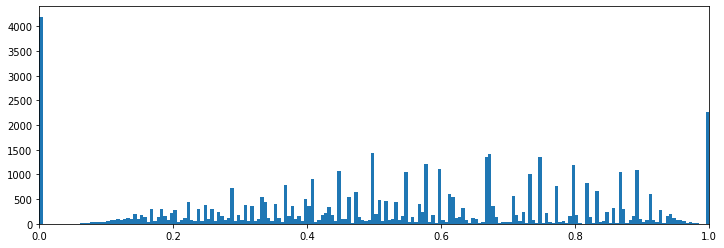

In [63]:
plt.figure(figsize=(12,4))
plt.hist(cosine_sim, bins = 200)
plt.xlim(0,1)
plt.show()

In [90]:
# Function to report the quality of the model
def performance_report(value, score_list):
    # the value (0-1) is the cosine similarity score to determine if a pair of questions
    # have the same meaning or not.
    scores = []
    for score in score_list:
        if score >= value:
            scores.append(1)
        else:
            scores.append(0)

    accuracy = accuracy_score(df.is_duplicate, scores) * 100
    print("Accuracy score is {}% for cosine similarity of {}.".format(round(accuracy), value))
    print()
    print("Confusion Matrix:")
    print(confusion_matrix(train.is_duplicate, scores))
    
    print()
    print("Classification Report:")
    print(classification_report(train.is_duplicate, scores))


performance_report(0.99, cosine_sim)

Accuracy score is 62.0% for cosine similarity of 0.99.

Confusion Matrix:
[[29930  1420]
 [17807   842]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.95      0.76     31350
           1       0.37      0.05      0.08     18649

    accuracy                           0.62     49999
   macro avg       0.50      0.50      0.42     49999
weighted avg       0.53      0.62      0.50     49999



<b>Using Cosine similarity as a feature, we got accuracy of 62% for detecting duplicate questions.